# Graph Lab

## Header information:

  - Author #1: Luigi Quattrociocchi (quattrl@mcmaster.ca)
  - Author #2: Dennis Fong (fongd1@mcmaster.ca)
  - Gitlab URL: http://gitlab.cas.mcmaster.ca/quattrl/l1-graph-lab
  - Avenue to Learn group name: Graph 42

## Week 1

In [1]:
# Build a graph from the csv files
from graphlib.builders import TubemapCSVBuilder

tubemap_builder = TubemapCSVBuilder()
tubemap_graph = tubemap_builder.build("_dataset/london.stations.csv", "_dataset/london.connections.csv", "_dataset/london.lines.csv")

In [2]:
# Compute some metrics about the graph
from graphlib.metrics import NumberOfNodesMetric, NumberOfEdgesMetric, DegreeMetric

print(f"Number of nodes = {NumberOfNodesMetric(tubemap_graph)()}")
print(f"Number of edges = {NumberOfEdgesMetric(tubemap_graph)()}")

node_degrees = [DegreeMetric(tubemap_graph, x)() for x in tubemap_graph.adj]
avg_degree = sum(node_degrees) / len(node_degrees)
print(f"Average node degree = {avg_degree}")

Number of nodes = 302
Number of edges = 406
Average node degree = 2.6887417218543046


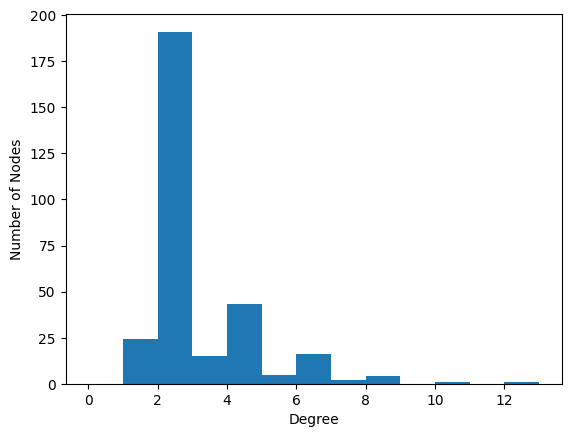

In [3]:
# Draw the distribution of node degrees
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

N = max(node_degrees) + 1
fig, ax = plt.subplots(1, 1)
N, bins, patches = ax.hist(node_degrees, bins=N, range=(0, N))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
_ = plt.xlabel("Degree")
_ = plt.ylabel("Number of Nodes")

Case "Dijkstra-1-1-1-Picadilly_Circus-St._Paul's":
KPI 1: Edges evaluated  = 172
KPI 2: Nodes evaluated  = 41
KPI 3: Edge relaxations = 60
Case "A*-1-1-1-Picadilly_Circus-St._Paul's":
KPI 1: Edges evaluated  = 73
KPI 2: Nodes evaluated  = 16
KPI 3: Edge relaxations = 33
Case "Dijkstra-1-0-0-Picadilly_Circus-St._Paul's":
KPI 1: Edges evaluated  = 149
KPI 2: Nodes evaluated  = 37
KPI 3: Edge relaxations = 56
Case "A*-1-0-0-Picadilly_Circus-St._Paul's":
KPI 1: Edges evaluated  = 73
KPI 2: Nodes evaluated  = 16
KPI 3: Edge relaxations = 33
Case "Dijkstra-1-1-100-Picadilly_Circus-St._Paul's":
KPI 1: Edges evaluated  = 298
KPI 2: Nodes evaluated  = 92
KPI 3: Edge relaxations = 135
Case "A*-1-1-100-Picadilly_Circus-St._Paul's":
KPI 1: Edges evaluated  = 73
KPI 2: Nodes evaluated  = 16
KPI 3: Edge relaxations = 33
Case "Dijkstra-1-1-1-Hammersmith-Stratford":
KPI 1: Edges evaluated  = 685
KPI 2: Nodes evaluated  = 220
KPI 3: Edge relaxations = 235
Case "A*-1-1-1-Hammersmith-Stratford":
KPI 1: E

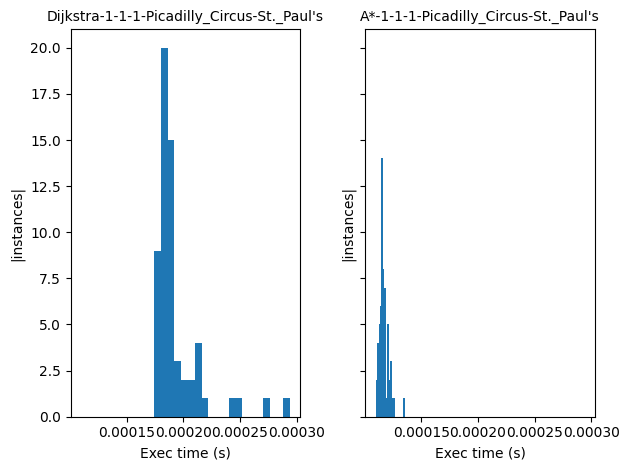

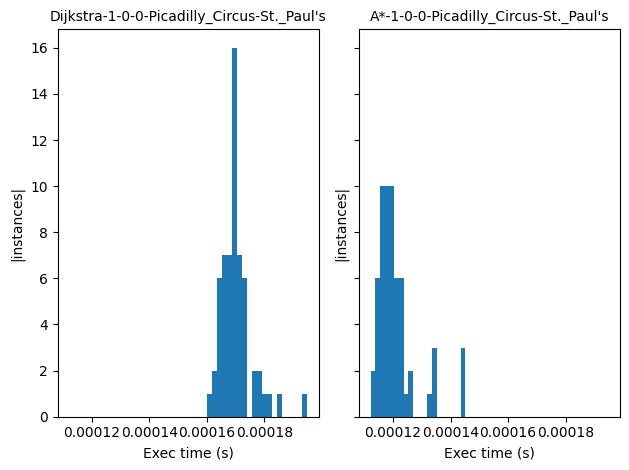

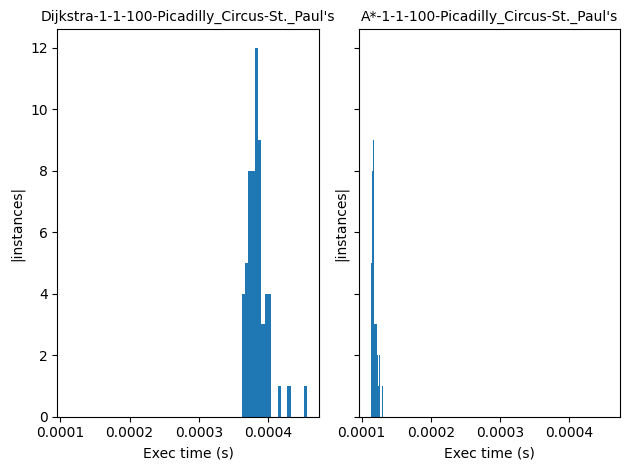

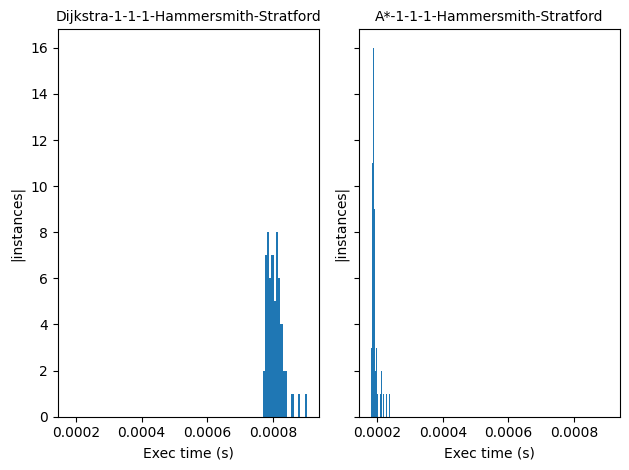

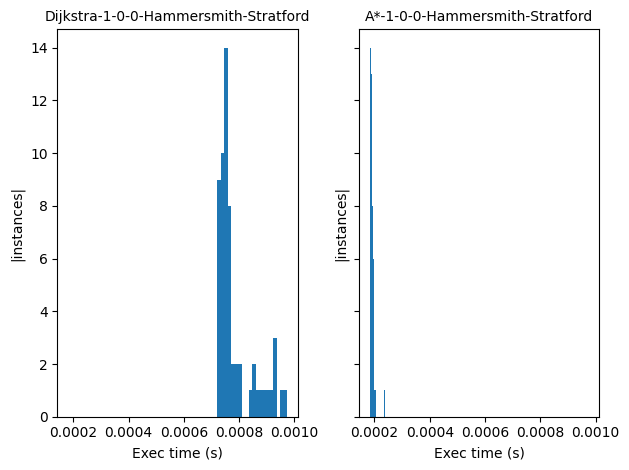

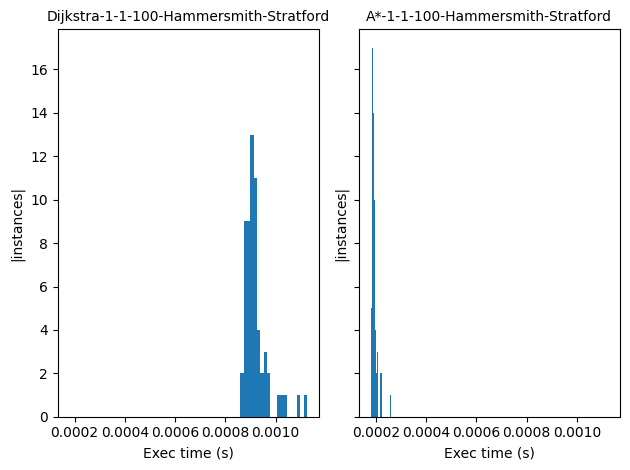

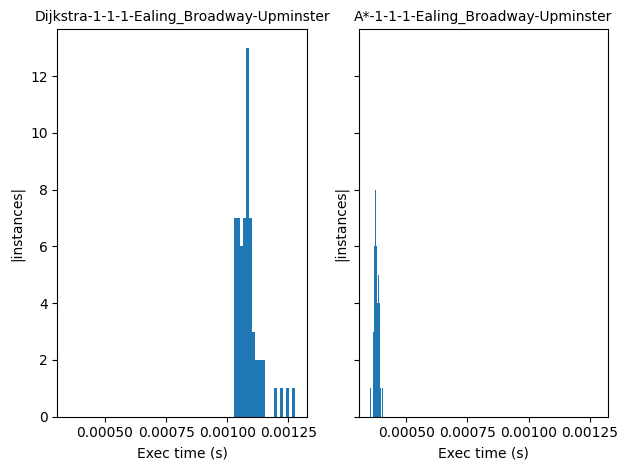

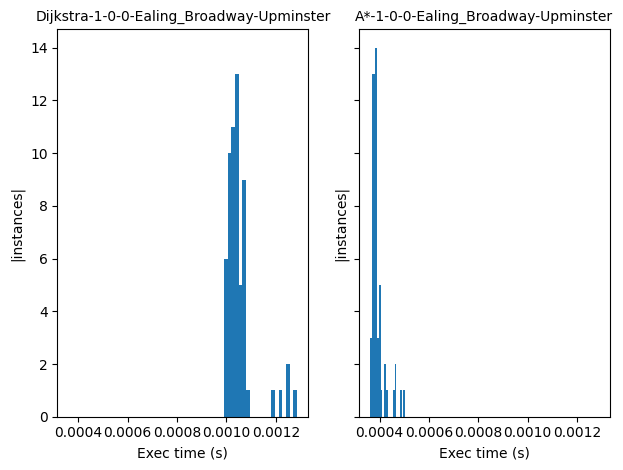

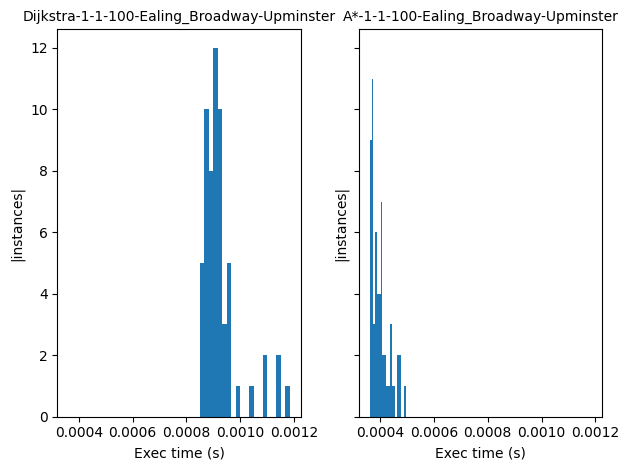

In [4]:
# Run and visualize benchmark
BENCHMARK_FILENAME = "outputs/pyperf_measurements.json"

# Run the benchmark only if a bencmkark results file outputted by pyperf does not exist
import os
if not os.path.exists(BENCHMARK_FILENAME):
    print("Running benchmark. This may take some time, go get a coffee or something...")
    !pipenv run python benchmark.py -o $BENCHMARK_FILENAME

# Print KPIs
from benchmark import london_tubemap_cases
for case in london_tubemap_cases():
    _p = case.func(*case.args)
    print(f'Case "{case.name}":')
    print(f"KPI 1: Edges evaluated  = {case.metric._edges_counter}")
    print(f"KPI 2: Nodes evaluated  = {case.metric._nodes_counter}")
    print(f"KPI 3: Edge relaxations = {case.metric._relaxation_counter}")
    print("=" * 60)

# Draw the results
from pyperf import BenchmarkSuite
benchmarks = BenchmarkSuite.load(BENCHMARK_FILENAME).get_benchmarks()
N = len(benchmarks)
for i in range(N//2):
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
    for j in range(2):
        bench = benchmarks[i*2 + j]
        ax = axs[j]
        ax.set_title(bench.get_name(), fontsize=10)
        ax.set(xlabel="Exec time (s)", ylabel="|instances|")
        ax.hist(bench.get_values(), 20)
    fig.tight_layout()

### Benchmark results analysis
It's clear to see that the A* algorithm has lower average execution times and lower KPIs in every category for every test case (see `benchmark.py` for test cases). This correlation makes sense: if a searching algorithm inspects fewer nodes, edges, and performs less relaxations, then does less work and will finish faster.
An important note to make here is the heuristic function used by the particular version of A* benchmarked. The heuristic function used is the Great-circle distance between the latitude and longitude points of the current station and the target station. This is a (mostly) accurate way to measure the distance between two points given their positions on the earth, and for points this close together we could even have used the euclidian distance between the points (essentially projecting the points onto a plane). For the london tubemap data, [neither of these particular heuristics are necessarily admissible](https://en.wikipedia.org/wiki/Admissible_heuristic), and we can see that A* does not always return the "shortest" path by weight. This contributes to the margin of victory of A* over Dijkstra.

### Class diagram
TODO

### Justification of design choices
A couple important design decisions were made this week. Most notably: the separation of "builders" and "graphs", the structure and usage of "graph metrics", and the tubemap itinerary.  
The notion of a `GraphBuilder` (an abstract base class) was introduced to generalize the production/building of some kind of graph. It is important that this functionality is distinct from the graph class itself to reduce the coupling between the format of the input and the graph, while maintaining cohesion.  
The `GraphBuilder` has an abstract method called `build`, which takes some (arbitrary) arguments and returns a graph, created from those arguments. In our case, a concrete implemenation of `GraphBuilder` called `TubemapCSVBuilder` takes three filenames of .csv files of stations, connections, and lines, and returns a bidirectional graph (`BiGraph`) class from the contents of those files. If a new kind of representation of a graph comes in some other form (different file format, input stream, existing graph, etc), a new subclass of `GraphBuilder` can be created. This is similar to the factory design pattern, however having a dedicated builder class is more useful because additional information (perhaps a byproduct of the input used to build the graph) can be stored inside the class, separate from the graph.  
The graph metrics, like the graph builders, are entirely distinct from the graph class itself. This way, the SRP (single responsibility principle) is satisfied. Our library has an abstract base class `GraphMetric` which has an abstract `__call__` method. Each "metric" (any information that a user may want to extract from their graph) is implemented as a subclass of `GraphMetric`. To extract a metric, a user should instantiate the subclass of the desired metric and "call" that object. The design of this mechanism is intentional and important for satifying the Open/Closed principle; When a library writer want to add a new metric (extending functionality) without modifying (and potentially breaking) existing code, they should create a new subclass of `GraphMetric`.
The `TubemapItinerary` class is yet another practical application of a design pattern in our library. The class uses the strategy pattern to compute an optimal path between two stations. The itinerary class is constructed with the IDs of the starting and target nodes, and has a method `set_search_strategy` which takes a callable object (more specifically, a `PathMetric`, which is an abstract subclass of `GraphMetric`). The `PathMetric` dependency is injected into the itinerary class when it is set, and is called upon later when the itinerary's `shortest_path` method is called. The itinerary class was written in this way for SRP purposes: `TubemapItinerary` does not care about the graph or search strategy implementations, only that it can call back to something when it needs to compute the shortest path. `PathMetric` subclasses must (and do) satisfy the Liskov substitution principle for this to work. `TubemapItinerary` can call any `PathMetric` which implements the abstract `__call__` operator with the correct arguments.


### How we split the work and who did what?
The design and implementation of the library was done by both partners together in person during the first week. We agreed that it is beneficial to work together on one computer in the early stages, so that our rapid prototyping isn't slowed down by version control. On the weekend after the first week, we split up the final tasks; Dennis drew the class diagram and Luigi wrote the benchmark, then we checked each others work.

## Week 2

## Week 3